In [1]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/lineesha/Documents/GitHub/LLM-Loan-Confidence-Prediction/data/unemployment


In [2]:
import pandas as pd

demographic_data = pd.read_csv('../pct_white.csv')
difference_data = pd.read_csv('merged_data_unemployment_llama-3.3-70b-versatile.csv.csv')

print('read')

read


In [3]:
print("Demographic columns:\n", demographic_data.columns.tolist())
print("\nDifference columns:\n", difference_data.columns.tolist())

Demographic columns:
 ['NAME', 'pct_white', 'state', 'county', 'FIPS']

Difference columns:
 ['fips', 'county', 'unemployment_rate', 'rate_confidence', 'area_unemployment_rate', 'FIPS_Code', 'State', 'Area_Name', 'Attribute', 'Value', 'Unnamed: 10', 'Predicted-Actual']


In [4]:
merged = pd.merge(
    difference_data,
    demographic_data,
    left_on='fips',
    right_on='FIPS',
    how='inner'
)

In [5]:
#Number of counties with underestimated unemployment and higher-than-avg white populations 
white_avg = 59.8

underestimated = merged[
    (merged['Predicted-Actual'] < 0) &   #predicted < actual
    (merged['pct_white'] > white_avg)
]

underestimates = merged[(merged['Predicted-Actual'] < 0)]
num_underestimates = len(underestimates)
print(num_underestimates)

print("Total Counties:", len(merged))
print("Number of underestimated counties with above-average White population:", len(underestimated))
print("Out of total underestimated counties:", num_underestimates)
print("Percentage:", len(underestimated) / num_underestimates * 100)

479
Total Counties: 3130
Number of underestimated counties with above-average White population: 402
Out of total underestimated counties: 479
Percentage: 83.92484342379957


In [6]:
#Number of counties with overestimated credit score and higher-than-avg white populations 
white_avg = 59.8

overestimated = merged[
    (merged['Predicted-Actual'] > 0) &   # predicted < actual
    (merged['pct_white'] < white_avg)
]

overestimates = merged[(merged['Predicted-Actual'] > 0)]
num_overestimates = len(overestimates)

print("Total Counties:", len(merged))
print("Number of overestimated counties with below-average White population:", len(overestimated))
print("Out of total overestimated counties:", num_overestimates)
print("Percentage:", len(overestimated) / num_overestimates * 100)


Total Counties: 3130
Number of overestimated counties with below-average White population: 356
Out of total overestimated counties: 2643
Percentage: 13.469542186908814


In [7]:
#counties with higher than avg white population
higher_white = merged[(merged['pct_white']> white_avg)]
print("Percent counties w/ higher than avg white population:", len(higher_white)/len(merged)*100)

lower_white = merged[(merged['pct_white']< white_avg)]
print("Percent counties w/ lower than avg white population:", len(lower_white)/len(merged)*100)



Percent counties w/ higher than avg white population: 86.13418530351437
Percent counties w/ lower than avg white population: 13.833865814696486


In [8]:
##finding proportion of each population

print(len(underestimated)/len(lower_white))
print(len(overestimated)/len(higher_white))

0.9284064665127021
0.13204747774480713


In [9]:
corr = merged["Predicted-Actual"].corr(merged["pct_white"])
print("Correlation between % White population and predicted credit score:", corr)

Correlation between % White population and predicted credit score: -0.13525013930813545


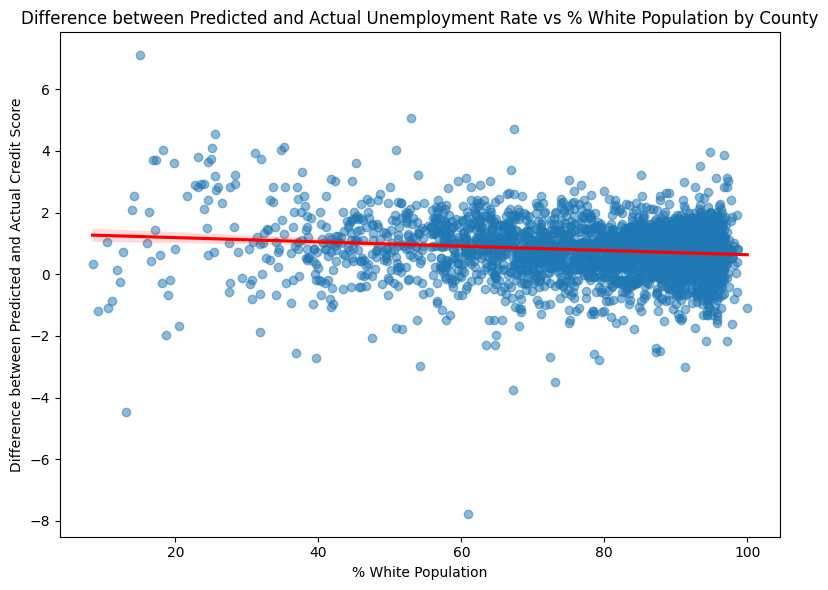

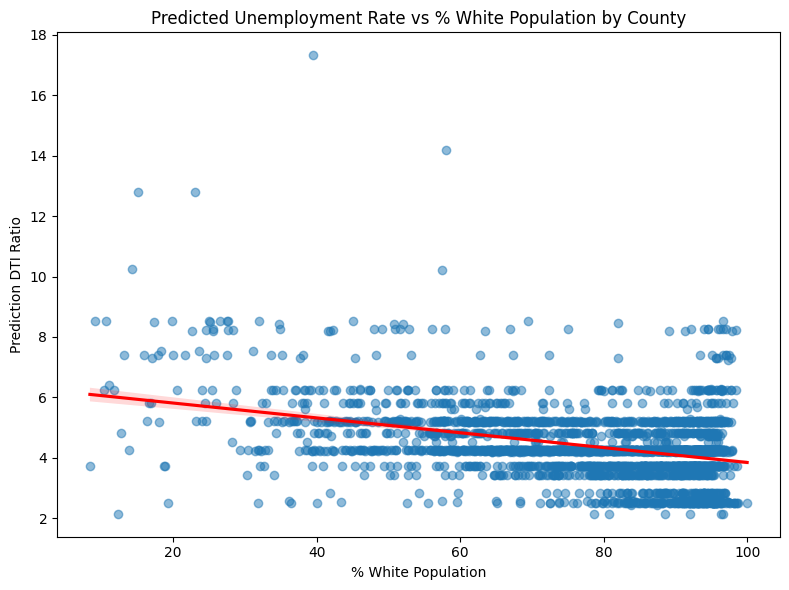

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(
    x="pct_white",
    y="Predicted-Actual",
    data=merged,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)

plt.title("Difference between Predicted and Actual Unemployment Rate vs % White Population by County")
plt.xlabel("% White Population")
plt.ylabel("Difference between Predicted and Actual Credit Score")
plt.tight_layout()
plt.show()

#identify who is disadvantaged or advantaged by the errors in prediction
#plot all 3 - debt, credit score, unemployment
#reference data and hypothesis data --> 2 diff graphs
#hypothesis data - if there is a negative correlation between debt in collections and credit score

plt.figure(figsize=(8, 6))
sns.regplot(
    x="pct_white",
    y="unemployment_rate",
    data=merged,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)

plt.title("Predicted Unemployment Rate vs % White Population by County")
plt.xlabel("% White Population")
plt.ylabel("Prediction DTI Ratio")
plt.tight_layout()
plt.show()



In [11]:
merged["bias_flag"] = (merged["Predicted-Actual"] < 0).astype(int)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = merged[["pct_white"]]
y = merged["bias_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       524
           1       0.00      0.00      0.00       102

    accuracy                           0.84       626
   macro avg       0.42      0.50      0.46       626
weighted avg       0.70      0.84      0.76       626

[[524   0]
 [102   0]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha